Header for notebooks -- customize as required.

In [1]:
# notebook configuration
COLAB = False # will trigger manual installation of packages
USE_GPU = True 

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"cleanlab_widedeep_{datetime.now().strftime('%Y%m%d')}.ipynb"

Now, non-stdlib imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
from sklearn.impute import SimpleImputer #, KNNImputer

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import RobustScaler #StandardScaler #, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft

# from BorutaShap import BorutaShap
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
from optuna.samplers import TPESampler
from sklearn.utils import resample

In [5]:
from cleanlab.classification import LearningWithNoisyLabels

In [6]:
from gauss_rank_scaler import GaussRankScaler

In [7]:
from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep#, SAINT, TabTransformer, TabNet, TabFastFormer, TabResnet
from pytorch_widedeep.metrics import Accuracy
from torchmetrics import AUROC
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

In [8]:
# import category_encoders as ce

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, datapath setup

In [9]:
if COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/nov2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    
    for pth in [datapath, predpath, subpath]:
        pth.mkdir(exist_ok=True)
    


## Helpers

In [10]:
SEED = 42

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=SEED)

In [11]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

## Metadata

In [12]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    # 'train_source': str(datapath/'X-RobustScaled-pca_mle-umap_embedding_20211107-n_comp10-n_neighbors15-rs42.joblib'),
    'train_source': str(datapath/'X_orig.feather'),
    'target_source': str(datapath/'y_orig.joblib'),
    # 'test_source': str(datapath/'X_test-RobustScaled-pca_mle-umap_embedding_20211107-n_comp10-n_neighbors15-rs42.joblib'),
    'test_source': str(datapath/'X_test_orig-no_scaling.feather'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
# X = load(dataset_params['train_source'])
X = pd.read_feather(dataset_params['train_source'])
y = load(dataset_params['target_source'])
# X_test = load(dataset_params['test_source'])
X_test = pd.read_feather(dataset_params['test_source'])

dataset_params['feature_count'] = X.shape[1]
dataset_params['instance_count'] = X.shape[0]
    

In [13]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
# in the sweep version, this includes both ex-model parameters and defaults for model parameters
exmodel_config = {
    "arch": 'widedeep-TabMLP',
    # "type": 'sweep',
    # "denoising": "cleanlab",
    "level": 1,
    'random_state': SEED,
    # 'tuner': "Optuna",
    'cross_val_strategy': None, # None for holdout, or the relevant sklearn class
    'kfolds': 1, # if 1, that means just doing holdout
    'test_size': 0.2,
    'scaler': str(GaussRankScaler()),
    **dataset_params
}

wandb_config = {
    # wandb config
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'project': '202111_Kaggle_tabular_playground',
    'tags': ['experiment'],
    'notes': "Testing to see if Cleanlab works with WideDeep models sans wrappers; also, comparing a baseline.",
    'config': exmodel_config,
}

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Noisy Run

## Preprocessing Data
Inspired a bit by Laurent Pourchot's Aug2021 Tabular Playground entry, I'm going to try to generate two versions of the dataset: a categorical one, using bins, and then (for now) a GaussRankScaled one. In the future, I might add further variations, e.g. with feature reduction via PCA and perhaps also UMAP and also denoising; I might also try other normalizations, e.g. Quantile.

## Binning (Generating wide cols)

In [14]:
# h/t Laurent Pourchot https://www.kaggle.com/pourchot/in-python-tabular-denoising-residual-network/

# 100 bins for the bins head of the NN (i.e. percentiles):
X_bins = np.zeros((X.shape[0],X.shape[1])) # he used all available data for the first tuple entry, but I'll start like this
X_test_bins = np.zeros((X_test.shape[0], X_test.shape[1]))

In [15]:
pd.qcut?

Signature:
pd.qcut(
    x,
    q,
    labels=None,
    retbins: bool = False,
    precision: int = 3,
    duplicates: str = 'raise',
)
Docstring:
Quantile-based discretization function.

Discretize variable into equal-sized buckets based on rank or based
on sample quantiles. For example 1000 values for 10 quantiles would
produce a Categorical object indicating quantile membership for each data point.

Parameters
----------
x : 1d ndarray or Series
q : int or list-like of float
    Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately
    array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
labels : array or False, default None
    Used as labels for the resulting bins. Must be of the same length as
    the resulting bins. If False, return only integer indicators of the
    bins. If True, raises an error.
retbins : bool, optional
    Whether to return the (bins, labels) or not. Can be useful if bins
    is given as a scalar.
precision : int, optional
    The pr

In [16]:
for i in range(X.shape[1]): # assumes X is a pd.DataFrame
    X_bins[:,i] = pd.qcut(X.iloc[:,i],X.shape[1],labels=False)#,duplicates = 'drop')
    
for i in range(X_test.shape[1]): # assumes X_test is a pd.DataFrame
    X_test_bins[:,i] = pd.qcut(X_test.iloc[:,i],X_test.shape[1], labels=False)#,duplicates = 'drop')
# blabeled = X_bins[:X.shape[0],:]
# bunlabeled = X_ins[X.shape[0]:,:]

In [17]:
np.isnan(X_test_bins).any()

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

In [18]:
# X_bins = X_bins.astype(np.int8)
# X_test_bins = X_test_bins.astype(np.int8)

In [19]:
X_bins = pd.DataFrame(X_bins, index=X.index, columns=[f'rkd_f{col}' for col in range(100)])
X_test_bins = pd.DataFrame(X_test_bins, index=X_test.index, columns=[f'rkd_f{col}' for col in range(100)])

## Normalizing (Preprocessing Deep Cols)

In [20]:
?GaussRankScaler

Init signature:
GaussRankScaler(
    epsilon=0.0001,
    copy=True,
    n_jobs=None,
    interp_kind='linear',
    interp_copy=False,
)
Docstring:     
Transform features by scaling each feature to a normal distribution.
Parameters
    ----------
    epsilon : float, optional, default 1e-4
        A small amount added to the lower bound or subtracted
        from the upper bound. This value prevents infinite number
        from occurring when applying the inverse error function.
    copy : boolean, optional, default True
        If False, try to avoid a copy and do inplace scaling instead.
        This is not guaranteed to always work inplace; e.g. if the data is
        not a NumPy array, a copy may still be returned.
    n_jobs : int or None, optional, default None
        Number of jobs to run in parallel.
        ``None`` means 1 and ``-1`` means using all processors.
    interp_kind : str or int, optional, default 'linear'
       Specifies the kind of interpolation as a string
   

In [ ]:
scaler = GaussRankScaler(n_jobs=-1, epsilon=0.005)
X_gauss = scaler.fit_transform(X)
X_test_gauss = scaler.transform(X_test)

In [ ]:
np.where(np.isnan(X_test_gauss))

In [20]:
X_gauss = pd.DataFrame(X_gauss, columns=X.columns, index=X.index)
X_test_gauss = pd.DataFrame(X_test_gauss, columns=X_test.columns, index=X_test.index)

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preparing Data for WideDeep

In [21]:
X_pre = X_gauss.join(X_bins)
X_test_pre = X_test_gauss.join(X_test_bins)

In [22]:
cont_cols = X_pre.iloc[:,:100].columns
wide_cols = X_pre.iloc[:, 100:].columns

In [26]:
np.where(np.isnan(X_test_bins))

(array([], dtype=int64), array([], dtype=int64))

In [25]:
X_test_gauss.shape

(540000, 100)

In [24]:
np.where(np.isnan(X_test_gauss))

(array([ 60187,  72708,  84460, 115714, 148146, 159870, 226322, 234164,
        314815, 329817, 344893, 348131, 350202, 357178, 405041, 494088,
        504259, 522269]),
 array([22, 22, 22, 67, 67, 67, 20, 20, 74, 95, 74, 95, 95, 67, 22, 80, 72,
        20]))

In [28]:
X_test_gauss.iloc[60187,20:24]

f20    0.625976
f21   -0.610742
f22         NaN
f23   -0.643657
Name: 60187, dtype: float64

In [29]:
X_test.iloc[60187, 20:24]

f20    0.094129
f21    0.013104
f22   -1.398120
f23   -0.004802
Name: 60187, dtype: float64

In [30]:
X_test.iloc[:,22].min()

-1.39812

In [32]:
X_test.iloc[84460,22]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1.28285

In [35]:
problems = np.where(np.isnan(X_test_pre))
problems

(array([ 60187,  72708,  84460, 115714, 148146, 159870, 226322, 234164,
        314815, 329817, 344893, 348131, 350202, 357178, 405041, 494088,
        504259, 522269]),
 array([22, 22, 22, 67, 67, 67, 20, 20, 74, 95, 74, 95, 95, 67, 22, 80, 72,
        20]))

In [36]:
for i in range(len(problems[0])):
    print(f"Value of X_test.iloc[{problems[0][i]},{problems[1][i]}] is {X_test.iloc[problems[0][i], problems[1][i]]}")

Value of X_test.iloc[60187,22] is -1.39812
Value of X_test.iloc[72708,22] is -1.29427
Value of X_test.iloc[84460,22] is -1.28285
Value of X_test.iloc[115714,67] is -1.12259
Value of X_test.iloc[148146,67] is -1.09674
Value of X_test.iloc[159870,67] is -1.09655
Value of X_test.iloc[226322,20] is -3.16541
Value of X_test.iloc[234164,20] is -3.02364
Value of X_test.iloc[314815,74] is -1.4098
Value of X_test.iloc[329817,95] is -1.90749
Value of X_test.iloc[344893,74] is -1.32339
Value of X_test.iloc[348131,95] is -1.86755
Value of X_test.iloc[350202,95] is -1.86068
Value of X_test.iloc[357178,67] is -1.3979
Value of X_test.iloc[405041,22] is -1.27897
Value of X_test.iloc[494088,80] is -1.35998
Value of X_test.iloc[504259,72] is -5.02689
Value of X_test.iloc[522269,20] is -3.1095


In [40]:
subzeros = np.where(X_test.iloc[:,22] < -1)
len(subzeros[0])

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


208

In [44]:
X_test.iloc[:,74].min()

-1.4098

In [22]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols)
X_wide = wide_preprocessor.fit_transform(X_pre)
X_test_wide = wide_preprocessor.transform(X_test_pre)

In [51]:
tab_preprocessor = TabPreprocessor(continuous_cols=cont_cols, scale=False, for_transformer=False,embed_cols=wide_cols, already_standard=True)
X_tab = tab_preprocessor.fit_transform(X_pre)
X_test_tab = tab_preprocessor.transform(X_test_pre)

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:179: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


In [24]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)

In [25]:
# deeptabular = TabMlp(continuous_cols=X_gauss.columns, column_idx=tab_preprocessor.column_idx)
deeptabular = TabMlp(continuous_cols=cont_cols, column_idx=tab_preprocessor.column_idx)

In [26]:
model = WideDeep(wide=wide, deeptabular=deeptabular)

In [27]:
# del X_deep_train, X_deep_valid
X_wide_train, X_wide_valid, y_train, y_valid = train_test_split(X_wide, y, test_size=0.2, random_state=42)
X_tab_train, X_tab_valid, _, _ = train_test_split(X_tab, y, test_size=0.2, random_state=42)

In [28]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [29]:
n_epochs = 4

wide_opt = AdamW(model.wide.parameters(), lr=0.1)
deep_opt = AdamW(model.deeptabular.parameters(), lr=0.1)

wide_sch = OneCycleLR(optimizer=wide_opt, max_lr=0.01, steps_per_epoch=X_wide_train.shape[0], epochs=n_epochs)
deep_sch = OneCycleLR(optimizer=deep_opt, max_lr=0.01, steps_per_epoch=X_tab_train.shape[0], epochs=n_epochs)

optimizers = {'wide': wide_opt, 'deeptabular': deep_opt }
lr_schedulers = {'wide': wide_sch, 'deeptabular': deep_sch }


callbacks = [
    LRHistory(n_epochs=n_epochs), 
]

# trainer
trainer = Trainer(model=model, 
                  objective='binary', 
                  metrics=[Accuracy], # with AUROC got TypeError: '>' not supported between instances of 'NoneType' and 'int' 
                  seed=42, 
                  optimizers=optimizers,
                  callbacks=callbacks
                 )

#             print(f"type(X_train_wide) is {type(X_train_wide)} and type(X_train_tab) is {type(X_train_tab)}")
trainer.fit( # this is where problem is beginning
    X_wide=X_wide_train,
    X_tab=X_tab_train,
    target=y_train,
    n_epochs=n_epochs,
    batch_size=1024, # default value is 32
#                 val_split=0.2, # no need for this
)

y_valid_preds = trainer.predict_proba(X_wide=X_wide_valid, X_tab=X_tab_valid, batch_size=1024)[:,1]
           
    

predict: 100%|██████████| 118/118 [00:01<00:00, 83.19it/s] 


In [30]:
dirty_preds = trainer.predict_proba(X_wide=X_test_wide, X_tab=X_test_tab, batch_size=1024,)[:,1]
np.isnan(dirty_preds).any()

predict: 100%|██████████| 528/528 [00:03<00:00, 150.22it/s]


True

In [31]:
np.isnan(y_valid_preds).any()

False

In [32]:
np.isnan(X_test_wide).any()

False

In [33]:
np.isnan(X_tab).any()

False

In [34]:
np.isnan(X_test_tab).any()

True

<AxesSubplot:>

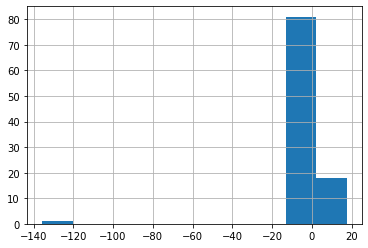

In [35]:
X_test.iloc[60187].hist()

<AxesSubplot:>

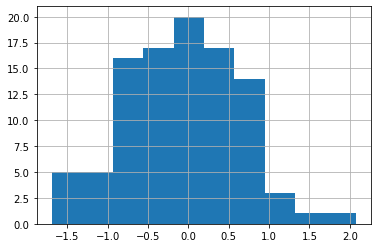

In [36]:
X_test_gauss.iloc[60187].hist()

<AxesSubplot:>

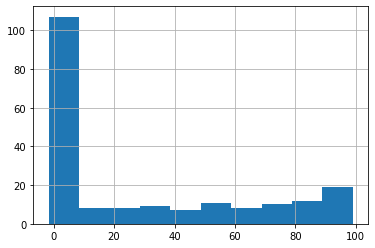

In [37]:
X_test_tab_df = pd.DataFrame(X_test_tab)
X_test_tab_df.iloc[60187].hist()

In [38]:
X_test_tab_df.iloc[60187].min(), X_test_tab_df.iloc[60188].min()

(-1.6916033346222619, -1.3556376794533695)

In [39]:
X_test_tab_df.iloc[:60187].min().min()

-2.8367347150190154

In [40]:
nan_rows = {}
for i in range(X_test_tab.shape[0]):
    if np.isnan(X_test_tab[i,:]).any():
        nan_rows[i] = X_test_tab[i]

In [41]:
nan_rows

{60187: array([ 2.00000000e+01,  6.20000000e+01,  7.50000000e+01,  8.70000000e+01,
         9.60000000e+01,  7.80000000e+01,  9.90000000e+01,  5.70000000e+01,
         7.80000000e+01,  9.10000000e+01,  8.50000000e+01,  8.80000000e+01,
         9.40000000e+01,  6.00000000e+00,  8.90000000e+01,  3.30000000e+01,
         9.70000000e+01,  7.90000000e+01,  7.40000000e+01,  5.00000000e+00,
         9.60000000e+01,  3.60000000e+01,  5.00000000e+01,  8.70000000e+01,
         9.90000000e+01,  6.00000000e+01,  5.00000000e+01,  7.00000000e+00,
         1.40000000e+01,  5.90000000e+01,  4.50000000e+01,  2.50000000e+01,
         6.60000000e+01,  5.70000000e+01,  9.90000000e+01,  8.60000000e+01,
         3.70000000e+01,  9.30000000e+01,  2.40000000e+01,  7.00000000e+00,
         5.10000000e+01,  1.50000000e+01,  4.60000000e+01,  7.00000000e+01,
         9.00000000e+00,  6.80000000e+01,  4.00000000e+01,  5.80000000e+01,
         6.30000000e+01,  3.40000000e+01,  4.30000000e+01,  9.00000000e+01,
     

In [42]:
X_test_gauss

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.619456,1.034341,0.645473,-0.052261,0.978103,0.522698,-0.798766,-0.277188,1.022354,0.045579,...,0.758619,-0.363401,0.490163,0.613421,-0.180887,-0.600123,-0.869643,-0.141218,0.594689,-0.482751
1,-0.567866,-0.696955,-1.432455,0.168759,-0.323556,-0.348300,1.067404,0.049692,0.825306,0.135438,...,-1.114748,0.129868,0.494850,-0.243438,0.619959,-0.678709,-1.463564,0.435769,-0.050832,0.600260
2,1.206383,0.061464,-1.530707,0.342272,0.997053,0.710229,-0.247613,0.883862,-0.103971,-0.586893,...,-0.939646,-0.047713,-0.602895,0.569476,0.622574,1.163285,0.591371,0.298905,0.506683,0.127049
3,0.184687,0.248307,0.181383,-0.740751,0.010582,-0.029469,-0.255650,-0.730853,-0.240765,-1.070235,...,0.002933,-0.867166,-0.131024,1.286736,-0.532227,-0.493061,0.108958,-1.577487,0.001990,-0.494960
4,0.157196,1.299613,-0.026028,-1.526828,0.250719,-0.760238,-0.698085,1.238770,-1.372741,-0.269681,...,0.119485,0.140863,0.543735,-0.193285,0.442053,0.001422,-0.368938,0.393910,0.641184,-1.435955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,0.507008,-0.207350,-0.502140,0.143403,1.900548,1.163096,0.079889,-0.553810,0.959593,-0.315222,...,0.447478,0.107727,0.532786,-0.139661,0.610087,-0.404615,0.259662,-0.354882,0.075677,-0.277749
539996,-0.104095,0.039292,-1.646022,0.081841,1.265921,0.668651,-0.134541,-0.042641,0.212338,-0.387411,...,0.373597,0.615707,0.651895,0.253837,0.300526,-1.166199,0.810811,0.127410,-0.376520,0.290122
539997,0.456958,0.086246,-1.131546,-0.510218,-0.135827,-0.519311,-0.134625,-0.268035,-0.079109,0.548425,...,0.143556,0.449236,0.328486,0.274952,0.575756,0.730754,-0.677356,-2.516733,1.074364,0.615870
539998,1.407662,0.358961,-0.485754,-1.199317,-0.324590,-0.046943,0.009755,0.045260,0.353344,0.463247,...,-0.967161,-0.940818,0.394077,-0.087183,-0.420167,0.279124,-1.404330,-0.784474,0.023141,0.324843


In [43]:
X_test_pre

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,rkd_f90,rkd_f91,rkd_f92,rkd_f93,rkd_f94,rkd_f95,rkd_f96,rkd_f97,rkd_f98,rkd_f99
0,-0.619456,1.034341,0.645473,-0.052261,0.978103,0.522698,-0.798766,-0.277188,1.022354,0.045579,...,84.0,18.0,74.0,76.0,33.0,19.0,8.0,35.0,80.0,19.0
1,-0.567866,-0.696955,-1.432455,0.168759,-0.323556,-0.348300,1.067404,0.049692,0.825306,0.135438,...,3.0,50.0,75.0,34.0,80.0,16.0,1.0,70.0,40.0,78.0
2,1.206383,0.061464,-1.530707,0.342272,0.997053,0.710229,-0.247613,0.883862,-0.103971,-0.586893,...,6.0,39.0,16.0,75.0,80.0,96.0,81.0,61.0,72.0,51.0
3,0.184687,0.248307,0.181383,-0.740751,0.010582,-0.029469,-0.255650,-0.730853,-0.240765,-1.070235,...,42.0,5.0,38.0,96.0,17.0,23.0,53.0,0.0,43.0,19.0
4,0.157196,1.299613,-0.026028,-1.526828,0.250719,-0.760238,-0.698085,1.238770,-1.372741,-0.269681,...,49.0,51.0,79.0,37.0,66.0,49.0,24.0,67.0,83.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,0.507008,-0.207350,-0.502140,0.143403,1.900548,1.163096,0.079889,-0.553810,0.959593,-0.315222,...,67.0,49.0,78.0,40.0,79.0,27.0,63.0,22.0,47.0,29.0
539996,-0.104095,0.039292,-1.646022,0.081841,1.265921,0.668651,-0.134541,-0.042641,0.212338,-0.387411,...,63.0,78.0,85.0,61.0,59.0,5.0,89.0,51.0,24.0,60.0
539997,0.456958,0.086246,-1.131546,-0.510218,-0.135827,-0.519311,-0.134625,-0.268035,-0.079109,0.548425,...,50.0,69.0,62.0,62.0,76.0,88.0,13.0,0.0,94.0,79.0
539998,1.407662,0.358961,-0.485754,-1.199317,-0.324590,-0.046943,0.009755,0.045260,0.353344,0.463247,...,5.0,4.0,65.0,43.0,21.0,65.0,1.0,8.0,44.0,62.0


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

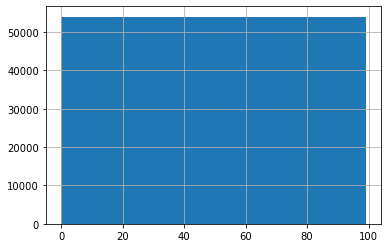

In [44]:
X_test_pre.iloc[:, 122].hist()

- Nothing much out of the ordinary here

In [45]:
np.where(np.isnan(X_test_tab[:,122]))

(array([ 60187,  72708,  84460, 405041]),)

In [46]:
X_test_tab_df.iloc[:,:100]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,71.0,100.0,15.0,6.0,77.0,52.0,31.0,78.0,18.0,28.0,...,73.0,38.0,66.0,77.0,7.0,97.0,69.0,42.0,58.0,27.0
1,9.0,66.0,19.0,86.0,5.0,100.0,8.0,62.0,16.0,8.0,...,40.0,76.0,19.0,34.0,89.0,84.0,37.0,29.0,73.0,20.0
2,51.0,14.0,22.0,12.0,84.0,94.0,39.0,24.0,31.0,62.0,...,4.0,88.0,95.0,56.0,89.0,10.0,33.0,100.0,82.0,42.0
3,2.0,61.0,16.0,44.0,30.0,19.0,79.0,16.0,98.0,12.0,...,92.0,98.0,16.0,36.0,73.0,30.0,49.0,98.0,96.0,27.0
4,64.0,63.0,9.0,39.0,78.0,38.0,46.0,77.0,41.0,57.0,...,44.0,79.0,61.0,93.0,22.0,8.0,59.0,58.0,78.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,54.0,75.0,93.0,75.0,87.0,2.0,4.0,19.0,13.0,66.0,...,47.0,89.0,87.0,35.0,5.0,29.0,63.0,76.0,92.0,90.0
539996,43.0,40.0,22.0,47.0,98.0,33.0,70.0,48.0,83.0,42.0,...,37.0,80.0,58.0,80.0,78.0,85.0,99.0,95.0,53.0,69.0
539997,68.0,13.0,97.0,64.0,42.0,79.0,70.0,91.0,60.0,37.0,...,49.0,26.0,32.0,66.0,3.0,11.0,95.0,98.0,14.0,36.0
539998,97.0,31.0,93.0,87.0,5.0,31.0,28.0,94.0,53.0,56.0,...,84.0,72.0,6.0,53.0,91.0,20.0,37.0,25.0,35.0,73.0


In [47]:
X_test_tab_df.index = X_test_pre.index
X_test_tab_df.columns = X_test_pre.columns

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
X_test_tab_df.compare(X_test_pre)

f0               f1              f2              f3              f4  \
        self     other   self     other  self     other  self     other  self   
0       71.0 -0.619456  100.0  1.034341  15.0  0.645473   6.0 -0.052261  77.0   
1        9.0 -0.567866   66.0 -0.696955  19.0 -1.432455  86.0  0.168759   5.0   
2       51.0  1.206383   14.0  0.061464  22.0 -1.530707  12.0  0.342272  84.0   
3        2.0  0.184687   61.0  0.248307  16.0  0.181383  44.0 -0.740751  30.0   
4       64.0  0.157196   63.0  1.299613   9.0 -0.026028  39.0 -1.526828  78.0   
...      ...       ...    ...       ...   ...       ...   ...       ...   ...   
539995  54.0  0.507008   75.0 -0.207350  93.0 -0.502140  75.0  0.143403  87.0   
539996  43.0 -0.104095   40.0  0.039292  22.0 -1.646022  47.0  0.081841  98.0   
539997  68.0  0.456958   13.0  0.086246  97.0 -1.131546  64.0 -0.510218  42.0   
539998  97.0  1.407662   31.0  0.358961  93.0 -0.485754  87.0 -1.199317   5.0   
539999  10.0  0.554393   54.0  0.125147  24.0  0.473817  21.0  0.849644  29.0   

                  ...   rkd_f95         rkd_f96         rkd_f97        \
           other  ...      self other      self other      self other   
0       0.978103  ... -0.600123  19.0 -0.869643   8.0 -0.141218  35.0   
1      -0.323556  ... -0.678709  16.0 -1.463564   1.0  0.435769  70.0   
2       0.997053  ...  1.163285  96.0  0.591371  81.0  0.298905  61.0   
3       0.010582  ... -0.493061  23.0  0.108958  53.0 -1.577487   0.0   
4       0.250719  ...  0.001422  49.0 -0.368938  24.0  0.393910  67.0   
...          ...  ...       ...   ...       ...   ...       ...   ...   
539995  1.900548  ... -0.404615  27.0  0.259662  63.0 -0.354882  22.0   
539996  1.265921  ... -1.166199   5.0  0.810811  89.0  0.127410  51.0   
539997 -0.135827  ...  0.730754  88.0 -0.677356  13.0 -2.516733   0.0   
539998 -0.324590  ...  0.279124  65.0 -1.404330   1.0 -0.784474   8.0   
539999  0.135994  ... -0.007671  49.0 -0.355156  25.0 -0.880579   6.0   

         rkd_f98         rkd_f99        
            self other      self other  
0       0.594689  80.0 -0.482751  19.0  
1      -0.050832  40.0  0.600260  78.0  
2       0.506683  72.0  0.127049  51.0  
3       0.001990  43.0 -0.494960  19.0  
4       0.641184  83.0 -1.435955   1.0  
...          ...   ...       ...   ...  
539995  0.075677  47.0 -0.277749  29.0  
539996 -0.376520  24.0  0.290122  60.0  
539997  1.074364  94.0  0.615870  79.0  
539998  0.023141  44.0  0.324843  62.0  
539999  0.199633  54.0  0.523092  72.0  

[540000 rows x 400 columns]

In [49]:
X_test_tab_reordered = X_test_tab_df.iloc[:, 100:].join(X_test_tab_df.iloc[:, :100])

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
X_test_tab_reordered.columns = X_test_pre.columns

In [87]:
X_test_tab_reordered.compare(X_test_pre)

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f0                  f1                  f2                  f3  \
            self     other      self     other      self     other      self   
0      -0.944192 -0.619456  1.494019  1.034341  0.942166  0.645473 -0.177913   
1      -0.869091 -0.567866 -1.198756 -0.696955 -2.210408 -1.432455  0.168864   
2       1.713748  1.206383 -0.019148  0.061464 -2.359474 -1.530707  0.441106   
3       0.226428  0.184687  0.271459  0.248307  0.238061  0.181383 -1.258147   
4       0.186409  0.157196  1.906609  1.299613 -0.076616 -0.026028 -2.491493   
...          ...       ...       ...       ...       ...       ...       ...   
539995  0.695642  0.507008 -0.437247 -0.207350 -0.798960 -0.502140  0.129081   
539996 -0.193963 -0.104095 -0.053632  0.039292 -2.534425 -1.646022  0.032492   
539997  0.622783  0.456958  0.019397  0.086246 -1.753877 -1.131546 -0.896443   
539998  2.006757  1.407662  0.443565  0.358961 -0.774099 -0.485754 -1.977632   
539999  0.764622  0.554393  0.079902  0.125147  0.681734  0.473817  1.237167   

                        f4            ... rkd_f95       rkd_f96       rkd_f97  \
           other      self     other  ...    self other    self other    self   
0      -0.052261  1.384562  0.978103  ...    97.0  19.0    69.0   8.0    42.0   
1       0.168759 -0.529212 -0.323556  ...    84.0  16.0    37.0   1.0    29.0   
2       0.342272  1.412423  0.997053  ...    10.0  96.0    33.0  81.0   100.0   
3      -0.740751 -0.037943  0.010582  ...    30.0  23.0    49.0  53.0    98.0   
4      -1.526828  0.315120  0.250719  ...     8.0  49.0    59.0  24.0    58.0   
...          ...       ...       ...  ...     ...   ...     ...   ...     ...   
539995  0.143403  2.740795  1.900548  ...    29.0  27.0     NaN   NaN    76.0   
539996  0.081841  1.807729  1.265921  ...    85.0   5.0    99.0  89.0    95.0   
539997 -0.510218 -0.253203 -0.135827  ...    11.0  88.0    95.0  13.0    98.0   
539998 -1.199317 -0.530732 -0.324590  ...    20.0  65.0    37.0   1.0    25.0   
539999  0.849644  0.146444  0.135994  ...     8.0  49.0   100.0  25.0    68.0   

             rkd_f98       rkd_f99        
       other    self other    self other  
0       35.0    58.0  80.0    27.0  19.0  
1       70.0    73.0  40.0    20.0  78.0  
2       61.0    82.0  72.0    42.0  51.0  
3        0.0    96.0  43.0    27.0  19.0  
4       67.0    78.0  83.0    92.0   1.0  
...      ...     ...   ...     ...   ...  
539995  22.0    92.0  47.0    90.0  29.0  
539996  51.0    53.0  24.0    69.0  60.0  
539997   0.0    14.0  94.0    36.0  79.0  
539998   8.0    35.0  44.0    73.0  62.0  
539999   6.0    11.0  54.0    81.0  72.0  

[540000 rows x 400 columns]

In [52]:
np.where(np.isnan(X_test_pre))

(array([ 60187,  72708,  84460, 115714, 148146, 159870, 226322, 234164,
        314815, 329817, 344893, 348131, 350202, 357178, 405041, 494088,
        504259, 522269]),
 array([22, 22, 22, 67, 67, 67, 20, 20, 74, 95, 74, 95, 95, 67, 22, 80, 72,
        20]))

In [68]:
col122 = pd.Series(X_test_tab[:, 122])

<AxesSubplot:>

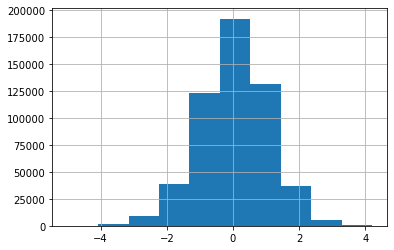

In [69]:
col122.hist()

In [71]:
len(col122.unique())

377808

In [72]:
min(col122.unique())

-4.995806994750132

In [73]:
max(col122.unique())

4.1986239759478385

In [56]:
problem_cols = []
for row in nan_rows.keys():
    col = np.where(np.isnan(nan_rows[row]))
    print(f"Row {row} has nan at {col}")
    if col not in problem_cols:
        problem_cols.append(col) 

Row 60187 has nan at (array([122]),)
Row 72708 has nan at (array([122]),)
Row 84460 has nan at (array([122]),)
Row 115714 has nan at (array([167]),)
Row 148146 has nan at (array([167]),)
Row 159870 has nan at (array([167]),)
Row 226322 has nan at (array([120]),)
Row 234164 has nan at (array([120]),)
Row 314815 has nan at (array([174]),)
Row 329817 has nan at (array([195]),)
Row 344893 has nan at (array([174]),)
Row 348131 has nan at (array([195]),)
Row 350202 has nan at (array([195]),)
Row 357178 has nan at (array([167]),)
Row 405041 has nan at (array([122]),)
Row 494088 has nan at (array([180]),)
Row 504259 has nan at (array([172]),)
Row 522269 has nan at (array([120]),)


In [57]:
problem_cols

[(array([122]),),
 (array([167]),),
 (array([120]),),
 (array([174]),),
 (array([195]),),
 (array([180]),),
 (array([172]),)]

In [36]:
len(nan_rows.keys())

18

In [30]:
dump(dirty_preds, predpath/'cleanlab_widedeep_20211123-TabMLP-dirtydata-holdout-baseline_preds.joblib')

predict: 100%|██████████| 528/528 [00:02<00:00, 211.57it/s]


['/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/preds/cleanlab_widedeep_20211123-TabMLP-dirtydata-holdout-baseline_preds.joblib']

In [31]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [32]:
sample_df.head()

,id,target
0,600000,0.5
1,600001,0.5
2,600002,0.5
3,600003,0.5
4,600004,0.5


In [33]:
sample_df.loc[:, 'target'] = dirty_preds

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
sample_df.head()

,id,target
0,600000,0.807969
1,600001,0.581973
2,600002,0.713237
3,600003,0.279203
4,600004,0.586826


In [35]:
sample_df.to_csv(subpath/f"{wandb_config['name']}-TabMLP-dirtydata-holdout-baseline_preds.csv", index=False)
# sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-X_orig+KMeans8+synth-GBM-stack_ensemble_preds.csv", index=False)

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
dirty_preds.shape

(540000,)

In [42]:
sample_df.shape

(540000, 2)

In [43]:
dirty_preds_float64 = dirty_preds.astype(np.float64)

In [44]:
sample_df.loc[:, 'target'] = dirty_preds

In [45]:
sample_df.head()

,id,target
0,600000,0.781741
1,600001,0.547938
2,600002,0.714756
3,600003,0.340266
4,600004,0.561223


In [46]:
sample_df.to_csv(subpath/f"{wandb_config['name']}-TabMLP-dirtydata-holdout-baseline_preds_floatified.csv", index=False)


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
wandb.init(
    project="202111_Kaggle_tabular_playground",
    save_code=True,
    tags=wandb_config['tags'],
    name=wandb_config['name'],
    notes=wandb_config['notes'],
    config=exmodel_config
) 

Problem at: <ipython-input-15-696801d16add> 1 <module>


KeyboardInterrupt: 

In [30]:


wandb.log({'overall_valid_auc': valid_auc,
           'model_params': str(lgb_model.get_params()),
           'model_seed': 42,
          })
wandb.finish()


model_seed,▁
overall_valid_auc,▁
model_params,{'boosting_type': 'g...
model_seed,42
overall_valid_auc,0.73222


## Clean Run

In [31]:
exmodel_config['denoising'] = 'cleanlab'

wandb_config = {
    # wandb config
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'project': '202111_Kaggle_tabular_playground',
    'tags': ['experiment'],
    'notes': "Going to try CleanLab with the 'best' params from the previous sweep, but wanting to see what the actual LB score is, and how it compares to the noisy one. Using a default LGBMClassfier with holdout on robust-scaled original dataset.",
    'config': exmodel_config,
}

wandb.init(
    project="202111_Kaggle_tabular_playground",
    save_code=True,
    tags=wandb_config['tags'],
    name=wandb_config['name'],
    notes=wandb_config['notes'],
    config=exmodel_config
) 

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
rp_params = {
    # 'prune_method': trial.suggest_categorical('prune_method', ['prune_by_noise_rate', 'prune_by_class', 'both']),
    # 'converge_latent_estimates': trial.suggest_categorical('converge_latent_estimates', [True, False]),
    # 'pulearning': trial.suggest_categorical('pulearning', [0,1,None])
    'prune_method': 'both',
    'converge_latent_estimates': True,
    'pulearning': 1,
}

In [33]:
lgb_model = LGBMClassifier(
        objective='binary',
        random_state=42,
        #                     device_type='cpu',
        #                     n_jobs=-1,
        #                 eval_metric='auc',
        device_type='gpu',
        max_bin=63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
        gpu_use_dp=False, # forces use of single precision rather than double for better perf, esp on consumer Nvidia chips
    )

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
scaler = RobustScaler()

In [36]:
scaler.fit_transform(X_train)

array([[-0.27296268,  0.01579322, -0.19031588, ...,  0.50363337,
         0.17720313, -0.58369832],
       [-0.18106382,  0.2410393 ,  5.30773161, ...,  0.24955035,
        -0.48450355, -0.62285755],
       [ 6.07300903, -0.85078822,  0.17280319, ..., -0.62764574,
        -0.67894852,  0.73726127],
       ...,
       [ 4.18856991, -0.68824246,  0.21225385, ...,  0.88726112,
         6.19955807, -0.09918299],
       [-0.300117  ,  0.13080398, -0.54802214, ..., -0.3979886 ,
        -0.01474   ,  0.22398866],
       [-0.29279129,  0.62179137,  0.07317624, ...,  0.14508993,
        12.038684  ,  0.6437292 ]])

In [37]:
scaler.transform(X_valid)

array([[ 1.27745959, -0.79095855,  3.57879036, ...,  0.40431588,
         0.30027418,  0.45467042],
       [-0.35032922, -0.36662758, -0.83368479, ...,  0.48734142,
        -0.59656634,  9.97028335],
       [ 2.07990909,  0.20997962, -0.0127639 , ..., -0.80240405,
        -0.22697866,  0.23615553],
       ...,
       [ 0.80633635,  0.39936366,  0.49845399, ...,  0.68680344,
        -1.04204429,  0.24502101],
       [-0.06863608, -0.27843164, -0.36283929, ...,  0.18702425,
         0.57010813, -0.05371796],
       [-0.3620719 , -0.30144763, -0.06982129, ..., -0.73907299,
        -1.0792864 ,  0.24365673]])

In [39]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [40]:
rp = LearningWithNoisyLabels(clf=lgb_model, **rp_params)
rp.fit(X_train, y_train)

LGBMClassifier(device_type='gpu', gpu_use_dp=False, max_bin=63,
               objective='binary', random_state=42)

In [41]:
preds = rp.predict_proba(X_valid)[:,1]
valid_auc = roc_auc_score(y_true=y_valid, y_score=preds)
valid_auc

0.7242336321944994

In [42]:
rp.get_params()

{'clf__boosting_type': 'gbdt',
 'clf__class_weight': None,
 'clf__colsample_bytree': 1.0,
 'clf__importance_type': 'split',
 'clf__learning_rate': 0.1,
 'clf__max_depth': -1,
 'clf__min_child_samples': 20,
 'clf__min_child_weight': 0.001,
 'clf__min_split_gain': 0.0,
 'clf__n_estimators': 100,
 'clf__n_jobs': -1,
 'clf__num_leaves': 31,
 'clf__objective': 'binary',
 'clf__random_state': 42,
 'clf__reg_alpha': 0.0,
 'clf__reg_lambda': 0.0,
 'clf__silent': 'warn',
 'clf__subsample': 1.0,
 'clf__subsample_for_bin': 200000,
 'clf__subsample_freq': 0,
 'clf__device_type': 'gpu',
 'clf__max_bin': 63,
 'clf__gpu_use_dp': False,
 'clf': LGBMClassifier(device_type='gpu', gpu_use_dp=False, max_bin=63,
                objective='binary', random_state=42),
 'converge_latent_estimates': True,
 'cv_n_folds': 5,
 'n_jobs': 16,
 'prune_method': 'both',
 'pulearning': 1,
 'seed': None}

In [43]:
wandb.log({'overall_valid_auc': valid_auc,
           'model_params': str(lgb_model.get_params()),
           'model_seed': 42,
           'cleanlab_params': str(rp.get_params())
          })
wandb.finish()


model_seed,▁
overall_valid_auc,▁
cleanlab_params,{'clf__boosting_type...
model_params,{'boosting_type': 'g...
model_seed,42
overall_valid_auc,0.72423


In [44]:
dump(preds, predpath/'cleanlab_lgbm_20211122.joblib')

['/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/preds/cleanlab_lgbm_20211122.joblib']

## Submission

In [59]:
X_test = pd.read_feather(dataset_params['test_source'])

In [60]:
scaler = RobustScaler()

In [61]:
scaler.fit(X)

RobustScaler()

In [62]:
scaler.transform(X_test)

array([[-2.54904070e-01,  8.92660373e-01,  1.74689787e+00, ...,
        -3.14632989e-01,  7.56057179e-01, -5.35039504e-01],
       [-2.40419666e-01, -7.73033673e-01, -9.03498547e-01, ...,
         4.04404276e-01, -1.09484041e-01,  7.09297297e-01],
       [ 3.67480353e+00, -3.04606091e-02, -9.53230106e-01, ...,
         2.60323086e-01,  5.22578209e-01,  7.16351788e-02],
       ...,
       [ 7.74437122e-01,  4.76283375e-03, -7.63896086e-01, ...,
        -1.52318988e+00,  7.39754091e+00,  7.52089854e-01],
       [ 4.71329335e+00,  3.45526482e-01, -4.12767694e-01, ...,
        -9.01228907e-01, -3.59849849e-02,  2.78337176e-01],
       [ 1.01900951e+00,  5.92913219e-02,  9.90131581e-01, ...,
        -9.60166650e-01,  1.45144893e-01,  5.01730920e-01]])

In [63]:
dirty_preds = rp.predict_proba(X_test)[:,1]
clean_preds = lgb_model.predict_proba(X_test)[:,1]

In [64]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [65]:
sample_df.head()

,id,target
0,600000,0.5
1,600001,0.5
2,600002,0.5
3,600003,0.5
4,600004,0.5


In [67]:
dirty_preds.shape

(540000,)

In [69]:
clean_preds.shape

(540000,)

In [68]:
sample_df.shape

(540000, 2)

In [70]:
sample_df.loc[:, 'target'] = dirty_preds

In [71]:
sample_df.head()

,id,target
0,600000,0.866322
1,600001,0.948761
2,600002,0.976896
3,600003,0.810975
4,600004,0.665766


In [ ]:
# submission_path = datapath/'submissions'
# submission_path.mkdir(exist_ok=True)

In [72]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_basic_LGBM_preds.csv", index=False)
# sample_df.to_csv(subpath/f"{wandb_config['name']}_3level-X_orig+KMeans8+synth-GBM-stack_ensemble_preds.csv", index=False)

In [73]:
sample_df.loc[:, 'target'] = clean_preds

In [74]:
sample_df.head()

,id,target
0,600000,0.647848
1,600001,0.632269
2,600002,0.797033
3,600003,0.556056
4,600004,0.410237


In [75]:
sample_df.to_csv(subpath/f"{wandb_config['name']}_cleanlab_basic_LGBM_preds.csv", index=False)


# CONCLUSION
Actually, Cleanlab works: LB score with cleaning is 0.72402 compared to 0.71712 with the dirty one.

In [19]:
def cross_validate_model(arch:str, X, y, X_test, params:dict={}, start_fold=0, 
                         exmodel_config=exmodel_config, wandb_config=wandb_config, 
                         random_state=42, shuffle_kfolds=True, wandb_tracked=True, encode_cats=False):
    """
    Function to handle model training process in the context of cross-validation -- via hold-out or via k-fold.
    If exmodel_config['cross_val_strategy'] == None, then any kfolds= input is ignored; otherwise, the number specified is used.
    
    :param kfolds: int specifying number of k-folds to use in cross-validation
    :param exmodel_config: dict containing general config including for cross-validation -- `kfold=1` implies hold-out
    """
#     if exmodel_config['kfolds'] == 1:
#         print("Proceeding with holdout")
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
#                                                           test_size=0.2, 
#                                                           random_state=SEED)                 
    
    # prepare for k-fold cross-validation; random-state here is notebook-wide, not per-model
    # shuffle on the initial sets, but not subsequently -- performing the same operation twice means a very different dataset
    if shuffle_kfolds:
        kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=True, random_state=SEED)
    else:
        kfold = exmodel_config['cross_val_strategy'](n_splits=exmodel_config['kfolds'], shuffle=False)
    
    if wandb_tracked:
        exmodel_config['arch'] = arch
        exmodel_config[f'{arch}_params'] = str(params)
        wandb.init(
            project="202111_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )   
    
    # setup for serialization
    # runpath = Path(modelpath/f"{wandb_config['name']}_{arch}_{exmodel_config['kfolds']}folds/")
    # (runpath).mkdir(exist_ok=True)
    
    
    # initialize lists for out-of-fold preds and ground truth
    oof_preds, oof_y = [], []
    
    # initialize a numpy.ndarray containing the fold-model's preds for test set
    test_preds = np.zeros((X_test.shape[0]))
    
    # if using deep learning with pytorch-widedeep, do data preprocessing now, before splits
    if 'widedeep' in arch:
        # NOTE THAT ENCODING NOT DEPLOYED FOR THIS YET
        # preprocessing first
        wide_cols = [f for f in X.columns if X[f].nunique() == 2] #list(X_train.columns) if X_train.iloc[:,f].nunique() == 2] # binary indicator vars are wide
        cont_cols = [f for f in X.columns if X[f].nunique() > 2] #list(X_train.columns) if X_train.iloc[:,f].nunique() > 2] # others are cont

        # wide part
        # wide_preprocessor = WidePreprocessor(wide_cols=wide_cols)
        # X_wide = wide_preprocessor.fit_transform(X)
#         print(f"X_wide.shape = {X_wide.shape}")
#         X_wide = np.array(X_train[wide_cols])
        

        # deep part
        tab_preprocessor = TabPreprocessor(continuous_cols=cont_cols)#, embed_cols=embed_cols, )
        X_tab = tab_preprocessor.fit_transform(X)   
#         print(f"X_tab.shape = {X_tab.shape}")
        
        # transforming the test set
        X_test_wide = wide_preprocessor.transform(X_test)
        X_test_tab = tab_preprocessor.transform(X_test)
        
        # at this point, X_wide, X_tab, X_test_wide, and X_test_tab will all be np.ndarrays
    
#     else: # if using a GBM, simply convert the pd.DataFrames to np.ndarrays
#         X = np.array(X) # CAN YOU USE CATEGORY_ENCODERS ON NP.NDARRAYS?
#         X_test = np.array(X_test)
    
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(X,y)):
#         print(f"type(train_ids) = {type(train_ids)} and train_ids.shape = {train_ids.shape}")
#         print(f"type(valid_ids) = {type(valid_ids)} and train_ids.shape = {valid_ids.shape}")
        if fold < start_fold: # skip folds that are already trained
            continue
        else:
            print(f"FOLD {fold}")
            print("---------------------------------------------------")
            y_train, y_valid = y[train_ids], y[valid_ids] # y will be an np.ndarray already; handling will be same regardless of model
            if 'widedeep' in arch: # handle wide and deep tabs in parallel
                X_train_wide, X_valid_wide = X_wide[train_ids, :], X_wide[valid_ids, :]
                X_train_tab, X_valid_tab = X_tab[train_ids, :], X_tab[valid_ids, :]
#                 print(f"X_train_wide.shape = {X_train_wide.shape}")
#                 print(f"X_train_tab.shape = {X_train_tab.shape}")
#                 print(f"X_test_wide.shape = {X_test_wide.shape}")
#                 print(f"X_test_tab.shape = {X_test_tab.shape}")
            else: # handle datasets for GBMs
                if isinstance(X, np.ndarray):
                    X_train, X_valid = X[train_ids], X[valid_ids]
                else:
                    X_train, X_valid = X.iloc[train_ids,:], X.iloc[valid_ids,:] # bc need pandas.DataFrames for ce
                # if encode_cats:
                #     encoder = ce.WOEEncoder(cols=categoricals)
                #     encoder.fit(X_train,y_train)
                #     X_train = encoder.transform(X_train)
                #     X_valid = encoder.transform(X_valid)
                # # exmodel_config['feature_count'] = len(X.columns)
                #     wandb.log({
                #         'feature_count': X_train.shape[1],
                #         'instance_count': X_train.shape[0],
                #         'encoder': str(encoder)
                #     })
#                 exmodel_config['instance_count'] = X_train.shape[0]
#                 exmodel_config['encoder'] = str(encoder)
#                     X_test = encoder.transform(X_test)
#                 y_train, y_valid = y[train_ids], y[valid_ids]
            
        # scaling
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
    
        # define models
        if arch == 'xgboost':
            model = XGBClassifier(
                booster='gbtree',
                tree_method='gpu_hist',
                random_state=random_state,
                n_jobs=-1, 
                verbosity=1, 
                objective='binary:logistic',
                **params)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
            else:
                model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]


        elif arch == 'lightgbm':
            try:
                model = LGBMClassifier(
                    objective='binary',
                    random_state=random_state,
#                     device_type='cpu',
#                     n_jobs=-1,
    #                 eval_metric='auc',
                    device_type='gpu',
                    max_bin=63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
                    gpu_use_dp=False, # forces use of single precision rather than double for better perf, esp on consumer Nvidia chips
                    **params)
                
                if wandb_tracked:
                    model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()],)
                else:
                    model.fit(X_train, y_train)
            except LightGBMError:
                model = LGBMClassifier(
                    objective='binary',
                    random_state=random_state,
                    device_type='cpu',
                    n_jobs=-1,
    #                 eval_metric='auc',
    #                 device_type='gpu',
    #                 max_bin=63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
    #                 gpu_use_dp=False, # forces use of single precision rather than double for better perf, esp on consumer Nvidia chips
                    **params)
                
                if wandb_tracked:
                    model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()],)
                else:
                    model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]

            
        elif arch == 'catboost':
            model = CatBoostClassifier(
                task_type='GPU',
                silent=True,
                random_state=random_state,
                **params) 
        
            model.fit(X_train, y_train)
            y_valid_preds = model.predict_proba(X_valid)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            # add the fold's predictions to the model's test-set predictions (will divide later)
            test_preds += model.predict_proba(X_test)[:,1]
            
        elif 'widedeep' in arch: # only coding for TabMlp right now
#             X_train = pd.DataFrame(X_train, columns=[f"f{x}" for x in range(X_train.shape[1])])
#             X_valid = pd.DataFrame(X_valid, columns=[f"f{x}" for x in range(X_valid.shape[1])])
#             X_test = pd.DataFrame(X_test, columns=[f"f{x}" for x in range(X_test.shape[1])])
            
            wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
            deeptabular = TabMlp(
                mlp_hidden_dims=[64,32],
                column_idx=tab_preprocessor.column_idx,
            #     embed_input=tab_preprocessor.embeddings_input,
                continuous_cols=cont_cols,
            )
            
            # model instantiation and training
            model = WideDeep(wide=wide, deeptabular=deeptabular)
            
            
            n_epochs = 300

            # pytorch hyperparams
            wide_opt = AdamW(model.wide.parameters(), lr=0.1)
            deep_opt = AdamW(model.deeptabular.parameters(), lr=0.1)
            
            wide_sch = OneCycleLR(optimizer=wide_opt, max_lr=0.01, steps_per_epoch=X_train_wide.shape[0], epochs=n_epochs)
            deep_sch = OneCycleLR(optimizer=deep_opt, max_lr=0.01, steps_per_epoch=X_train_tab.shape[0], epochs=n_epochs)
            
            optimizers = {'wide': wide_opt, 'deeptabular': deep_opt }
            lr_schedulers = {'wide': wide_sch, 'deeptabular': deep_sch }
            
            
            callbacks = [
                LRHistory(n_epochs=n_epochs), 
            ]
            
            # trainer
            trainer = Trainer(model=model, 
                              objective='binary', 
                              metrics=[Accuracy], # with AUROC got TypeError: '>' not supported between instances of 'NoneType' and 'int' 
                              seed=random_state, 
                              optimizers=optimizers,
                              callbacks=callbacks
                             )
            
#             print(f"type(X_train_wide) is {type(X_train_wide)} and type(X_train_tab) is {type(X_train_tab)}")
            trainer.fit( # this is where problem is beginning
                X_wide=X_train_wide,
                X_tab=X_train_tab,
                target=y_train,
                n_epochs=n_epochs,
                batch_size=1024, # default value is 32
#                 val_split=0.2, # no need for this
            )
            
            y_valid_preds = trainer.predict_proba(X_wide=X_valid_wide, X_tab=X_valid_tab, batch_size=1024)[:,1]
            
            # add the fold-model's OOF preds and ground truths to the out-of-loop lists
            oof_preds.extend(y_valid_preds)
            oof_y.extend(y_valid)
            
            
            # test set inference
            fold_test_preds = trainer.predict_proba(X_wide=X_test_wide, X_tab=X_test_tab, batch_size=1024)[:,1]
            test_preds += fold_test_preds
            

        
        
       
        
        

#         valid_loss = log_loss(y_valid, y_pred)
        # give the valid AUC score, for edification
        fold_valid_auc = roc_auc_score(y_valid, y_valid_preds)
        if wandb_tracked:
            wandb.log({f'fold{fold}_valid_roc_auc': fold_valid_auc})
        print(f"Valid AUC for fold {fold} is {fold_valid_auc}")   
        # dump(model, Path(runpath/f"{arch}_fold{fold}_rs{random_state}_model.joblib"))

    model_valid_auc = roc_auc_score(oof_y, oof_preds)
    print(f"Valid AUC score for {arch} model is {model_valid_auc}")
    if wandb_tracked:
        wandb.log({'overall_valid_auc': model_valid_auc,
                   'model_params': str(model.parameters()) if 'widedeep' in arch else str(model.get_params()),
                   'model_seed': random_state,
                  })
        wandb.finish()
    
    # finalize test preds
    test_preds /= exmodel_config['kfolds']
    
    # save OOF preds and test-set preds
#     if 'widedeep' in arch:
#         dump(oof_preds, Path(predpath/f"{wandb_config['name']}_{arch}_{exmodel_config['kfolds']}folds_{n_epochs}epochs-per-fold_rs{random_state}_oof_preds.joblib"))
#         dump(test_preds, Path(predpath/f"{wandb_config['name']}_{arch}_{exmodel_config['kfolds']}folds_{n_epochs}epochs-per-fold_rs{random_state}_test_preds.joblib"))
    
#     else:
#         dump(oof_preds, Path(predpath/f"{wandb_config['name']}_{arch}_{exmodel_config['kfolds']}folds_rs{random_state}_oof_preds.joblib"))
#         dump(test_preds, Path(predpath/f"{wandb_config['name']}_{arch}_{exmodel_config['kfolds']}folds_rs{random_state}_test_preds.joblib"))
    
    if not (datapath/f"{exmodel_config['kfolds']}folds_rs{SEED}_oof_y.joblib").is_file():
        dump(oof_y, predpath/f"{exmodel_config['kfolds']}folds_rs{SEED}_oof_y.joblib")
    
#     if wandb_tracked:
# #         if 'widedeep' in arch:
#         wandb.log({'model_valid_auc': model_valid_auc,
# #                    'oof_preds': oof_preds,
# #                    'test_preds': test_preds,
#                    'model_params': str(model.parameters()) if 'widedeep' in arch else str(model.get_params()), 
#         #                    'model_params': str(model.get_params()),
#         })
# #         wandb.log({'model_valid_auc': model_valid_auc,
# #                    'oof_preds': oof_preds,
# #                    'test_preds': test_preds,
# # #                    'model_params': str(model.get_params()),
# #                   })
#         wandb.finish()
    return oof_preds, test_preds
        